In [11]:
%config Completer.use_jedi=False

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from sklearn.base import BaseEstimator, TransformerMixin
from classes_for_pipeline_py import FeaturesAdder, DataDropper, CappedTargetDropper, small_Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso, Ridge
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve

RMSE = lambda y_true, y_test: np.sqrt(MSE(y_true, y_test))

In [13]:
HOUSING_DATASET_CSV = os.path.join(os.getcwd(), 'housing_dataset\housing_data.csv')

In [48]:
housing_dataset = pd.read_csv(HOUSING_DATASET_CSV)
print(housing_dataset.shape)
housing_dataset.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [49]:
# split the dataset
train, test = train_test_split(housing_dataset, test_size=0.2, random_state=42)

# split the training
X_train_pp, X_test_pp = train_test_split(train, test_size=0.2, random_state=42)

In [79]:
class PreprocessPipeline(BaseEstimator, TransformerMixin):
    
    '''any transformer can be access via 
    PreprocessPipeline.name_of_transformer.list_of_transformers[0][0].statistic_in_question'''
    
    def __init__(self):
        self.median_imputer = small_Pipeline([
            (SimpleImputer(strategy='median'), 
             ['longitude', 'latitude', 'housing_median_age',
              'total_rooms', 'total_bedrooms', 'population', 
              'households', 'median_income', 'median_house_value'])
        ])
        self.feature_adder = FeaturesAdder()
        self.outliers_dropper = small_Pipeline([
            (CappedTargetDropper(capped_val=500000.0), 'median_house_value'),
            (DataDropper(method='optimized'), 'income_per_household'),
            (DataDropper(method='optimized'), 'population_per_household'),
            (DataDropper(method='optimized', penalty=0.25), 'rooms_per_household'),
            (DataDropper(method='optimized', penalty=0.25), 'rooms_per_age')
        ])
        self.standardizer = small_Pipeline([
            (StandardScaler(), 
             ['longitude', 'latitude'])
        ])
        self.features_power_transformer = small_Pipeline([
            (PowerTransformer(),
             ['housing_median_age', 'total_rooms',
              'total_bedrooms', 'population', 'households', 'median_income',
              'rooms_per_household', 'income_per_household',
              'income_per_population', 'bedrooms_per_rooms',
              'population_per_household', 'rooms_per_age'])
        ])
        self.target_power_transformer = small_Pipeline([
            (PowerTransformer(), ['median_house_value'])
        ])
        
    def fit(self, X):
        
        self.median_imputer.fit(X)
        
        # since all the later methods are obtained with nans imputed and added
        # new features we have to transform X and add new features,
        # then fit the other classes
        X = self.median_imputer.transform(X)
        X = self.feature_adder.fit_transform(X)
        
        self.outliers_dropper.fit(X)
        self.standardizer.fit(X)
        self.features_power_transformer.fit(X)
        self.target_power_transformer.fit(X)
        
        return self
    
    def transform(self, X):
        
        X = self.median_imputer.transform(X)
        X = self.feature_adder.fit_transform(X)
        X = self.outliers_dropper.fit_transform(X)
        X = X.dropna()
        X = self.standardizer.transform(X)
        X = self.features_power_transformer.transform(X)
        X = self.target_power_transformer.transform(X)
        
        X_cat = X['ocean_proximity'].copy()
        X_num = X.drop(columns=['ocean_proximity'])
        
        X_cat.loc[X_cat == 'ISLAND'] = np.nan
        X_merged = pd.merge(X_num, pd.get_dummies(X_cat, drop_first=True), left_index=True, right_index=True)
        
        return X_merged

PP = PreprocessPipeline()

In [80]:
# fit and transform the data
PP.fit(X_train_pp)
X_train, X_test = PP.transform(X_train_pp), PP.transform(X_test_pp)

# split to features and target
X_train, X_test, y_train, y_test = X_train.drop(columns=['median_house_value']).values,\
                                   X_test.drop(columns=['median_house_value']).values,\
                                   X_train.loc[:, 'median_house_value'].values,\
                                   X_test.loc[:, 'median_house_value'].values

In [120]:
def metrics_summary(model, X, y):
    list_of_metrics = ['neg_root_mean_squared_error', 'neg_mean_absolute_error']
    for metric, name in zip(list_of_metrics, ['RMSE', 'MAE']):
        cv_score = -cross_val_score(model, X, y, scoring=metric, cv=5)
        print(f'{name}: {cv_score.mean().round(2)} +- {(2 * cv_score.std() / np.sqrt(5)).round(2)}')

def target_inverse(pipeline, target):
    '''
    The function inverses the predicted target, if the target was choosen to be
    power transformed.
    '''
    inv_target = pipeline.target_power_transformer\
                         .list_of_transformers[0][0]\
                         .inverse_transform(
                             target.reshape(-1, 1)
                         )
    return inv_target

def plot_learning_curves(model, X, y, metric='neg_root_mean_squared_error', train_size=np.linspace(0.05, 1, 5), cv=5):
    S, train_scores, test_scores = learning_curve(model, X, y, scoring=metric, train_sizes=train_size, cv=cv, shuffle=True)
    train_scores, test_scores = -train_scores, -test_scores
    
    plt.plot(S, test_scores.mean(axis=1))
    plt.fill_between(S, test_scores.mean(axis=1) + 2 * test_scores.std(axis=1) / np.sqrt(S), test_scores.mean(axis=1) - 2 * test_scores.std(axis=1) / np.sqrt(S), color='blue', alpha=0.1)
    
    plt.plot(S, train_scores.mean(axis=1))
    plt.fill_between(S, train_scores.mean(axis=1) + 2 * train_scores.std(axis=1) / np.sqrt(S), train_scores.mean(axis=1) - 2 * train_scores.std(axis=1) / np.sqrt(S), color='orange', alpha=0.1)
    
    plt.axhline(np.mean([test_scores.mean(axis=1)[-1], train_scores.mean(axis=1)[-1]]), color='grey', ls='--')
    plt.show()
    
def cv_with_inverse():
    return
def learning_curves_with_inverse():
    return

In [116]:
# Classical Linear Regression
LR = LinearRegression()
LR.fit(X_train, y_train)
y_pred_LR = LR.predict(X_test)

In [117]:
metrics_summary(LR, X_train, y_train)

RMSE: 0.53 +- 0.01
MAE: 0.4 +- 0.0


In [118]:
RMSE(target_inverse(PP, y_pred_LR), target_inverse(PP, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


64807.942381767854

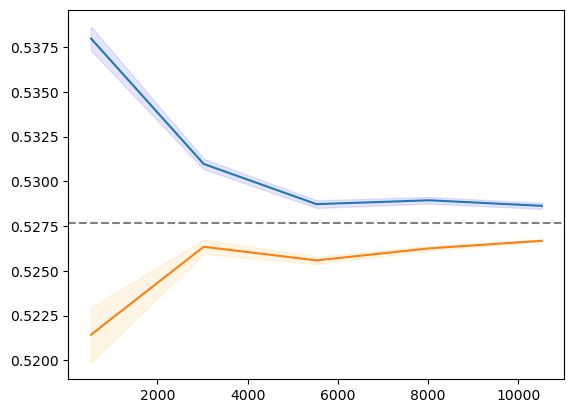

In [108]:
plot_learning_curves(LR, X_train, y_train, train_size=np.linspace(0.05, 1, 5))